In [11]:
import fastai
from fastai.vision.all import *
import os
from PIL import Image
import pandas as pd
import shutil


In [12]:
torch.cuda.empty_cache() 

#### Preprocessing

In [3]:
os.chdir('C:/Users/jwst2/Python/tesis/jpg/jabar10m_ur')
if os.path.isdir('urban') is False:
    os.makedirs('urban')
    os.makedirs('rural')

In [4]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/gen_desa_10m/"
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        if(sls.klas_ur[sls.iddesa == int(name.replace(".jpg",""))].iloc[0] == 1):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar10m_ur/urban/"+name)
        else:
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar10m_ur/rural/"+name)
    

1it [00:00, ?it/s]


#### Models

In [13]:
path = Path.cwd() / ("C:/Users/jwst2/Python/tesis/jpg/jabar10m_ur")

In [14]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('models'),Path('rural'),Path('urban')]

In [15]:
fname = (path/"rural").ls()[0]
fname

Path('rural/3201010001.jpg')

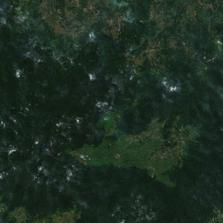

In [16]:
img = Image.open(fname)
img

In [17]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1,seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label, # extracts the label category from the image's folder name 
                 item_tfms = Resize(64)) # data augmentation (mult multiplies the default transformation values)

In [18]:
dls = blocks.dataloaders(path,bs=4)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


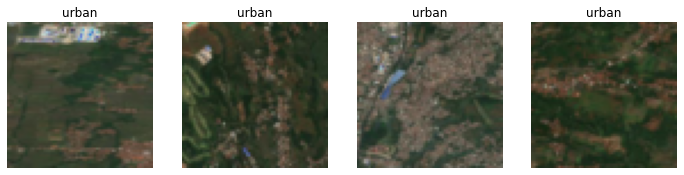

In [19]:
dls.show_batch(nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\torch\_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


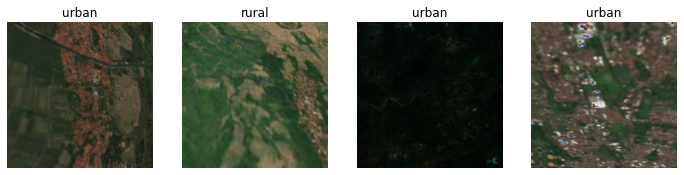

In [20]:
blocks = blocks.new(batch_tfms=aug_transforms(mult=2.0))
dls = blocks.dataloaders(path,bs=4)
dls.train.show_batch(nrows=1)

default.device = torch.device('cpu').#### Densenet

In [26]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s, roca]
learn = cnn_learner(dls, densenet121, metrics=metrics) 

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\fastai\callback\schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0002754228771664202)

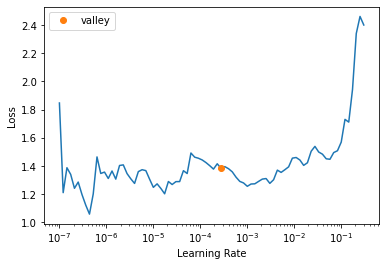

In [27]:
learn.lr_find()

In [28]:
learn.fit_one_cycle(5,0.0002)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.734989,0.488956,0.773109,0.733607,0.722266,0.733607,0.727239,0.824649,04:19
1,0.669698,0.469398,0.779832,0.666081,0.742628,0.666081,0.683717,0.829263,04:24
2,0.547096,0.389936,0.828571,0.786690,0.788792,0.786690,0.787726,0.880423,04:17
3,0.564825,0.388180,0.811765,0.724434,0.782456,0.724434,0.743471,0.881120,04:18
4,0.572011,0.371478,0.810084,0.748536,0.768291,0.748536,0.757047,0.891045,04:16


In [23]:
learn.fit_one_cycle(5,0.0002)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.458206,0.352568,0.816807,0.738778,0.784942,0.738778,0.755468,0.903758,04:08
1,0.504218,0.365044,0.831933,0.749317,0.813772,0.749317,0.770957,0.894349,04:11
2,0.473483,0.353818,0.835294,0.758880,0.814262,0.758880,0.778646,0.911146,04:15
3,0.464929,0.365738,0.833613,0.737851,0.831633,0.737851,0.764701,0.905710,04:15
4,0.444107,0.361436,0.831933,0.727654,0.840911,0.727654,0.756610,0.910254,04:18


In [29]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.603098,0.456901,0.756303,0.624415,0.705882,0.624415,0.636064,0.833961,04:02
1,0.592535,0.439190,0.774790,0.756440,0.729565,0.756440,0.738748,0.861590,04:12
2,0.534022,0.387726,0.808403,0.718482,0.778453,0.718482,0.737646,0.876882,04:15
3,0.430909,0.378717,0.821849,0.711602,0.828021,0.711602,0.739165,0.897736,04:16
4,0.444901,0.366501,0.843697,0.773761,0.823087,0.773761,0.792293,0.898433,04:15


In [33]:
learn.fit_one_cycle(1,0.0002)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.439718,0.351143,0.843697,0.773761,0.823087,0.773761,0.792293,0.910561,04:06


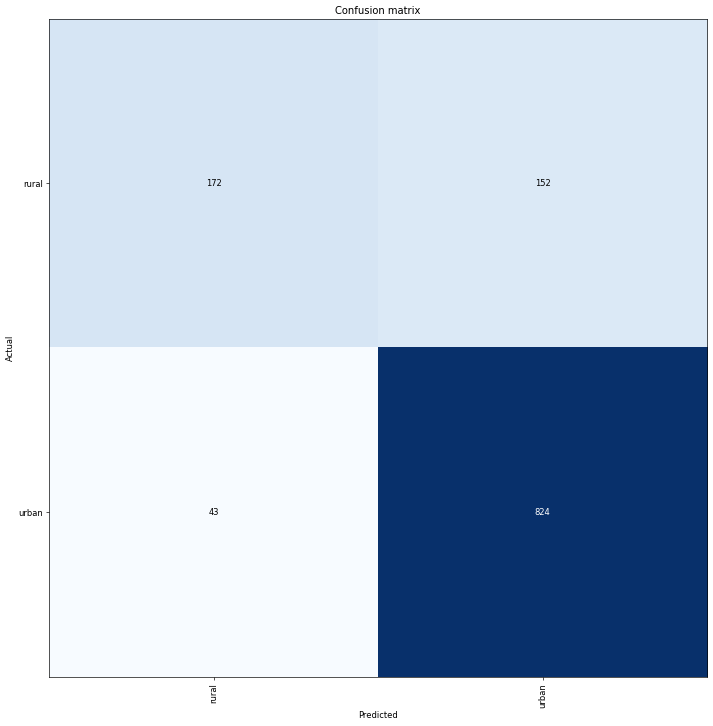

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [35]:
interp.most_confused(min_val=5)

NameError: name 'interp' is not defined

In [34]:
learn.export('C:/Users/jwst2/Python/tesis/models/18042022 D002.pkl')

#### Resnet

In [39]:
learn_rs = cnn_learner(dls, resnet50, metrics=metrics) 

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\fastai\callback\schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=2.2908675418875646e-06)

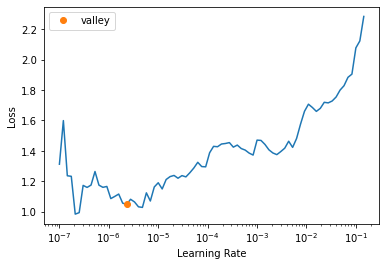

In [40]:
learn_rs.lr_find()

In [49]:
learn_rs.unfreeze()

In [41]:
learn_rs.fit_one_cycle(15)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.808475,0.639240,0.744538,0.704674,0.690806,0.704674,0.696363,0.762100,02:15
1,0.579481,0.526276,0.741176,0.718579,0.693939,0.718579,0.701469,0.816438,02:17
2,0.552227,0.491843,0.779832,0.741901,0.730158,0.741901,0.735321,0.844081,02:17
3,0.537271,0.440618,0.816807,0.735168,0.787149,0.735168,0.753235,0.843063,02:18
4,0.536523,0.450513,0.769748,0.635587,0.738605,0.635587,0.650032,0.841405,02:18
5,0.481314,0.450851,0.793277,0.780152,0.750224,0.780152,0.760540,0.873494,02:19
6,0.468826,0.372526,0.833613,0.768540,0.803925,0.768540,0.782703,0.887978,02:18
7,0.491017,0.398323,0.815126,0.719555,0.795220,0.719555,0.741851,0.880841,02:18
8,0.497560,0.387389,0.815126,0.699698,0.821084,0.699698,0.726270,0.896231,02:18
9,0.447381,0.372004,0.823529,0.725410,0.814286,0.725410,0.750440,0.899242,02:18


In [42]:
learn_rs.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.530477,0.382500,0.830252,0.737315,0.821365,0.737315,0.762377,0.886974,02:15
1,0.491225,0.408711,0.793277,0.650176,0.821429,0.650176,0.669637,0.885943,02:17
2,0.497313,0.437197,0.721008,0.505952,0.860034,0.505952,0.430392,0.887379,02:17
3,0.445890,0.363054,0.835294,0.749854,0.822574,0.749854,0.773381,0.904274,02:17
4,0.456123,0.367632,0.826891,0.718726,0.836086,0.718726,0.747246,0.909488,02:19


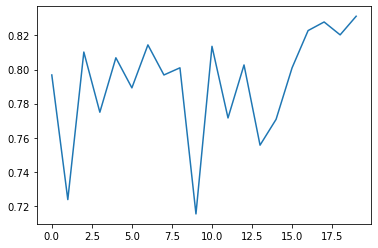

In [18]:
plt.plot(L(learn_rs.recorder.values).itemgot(2));

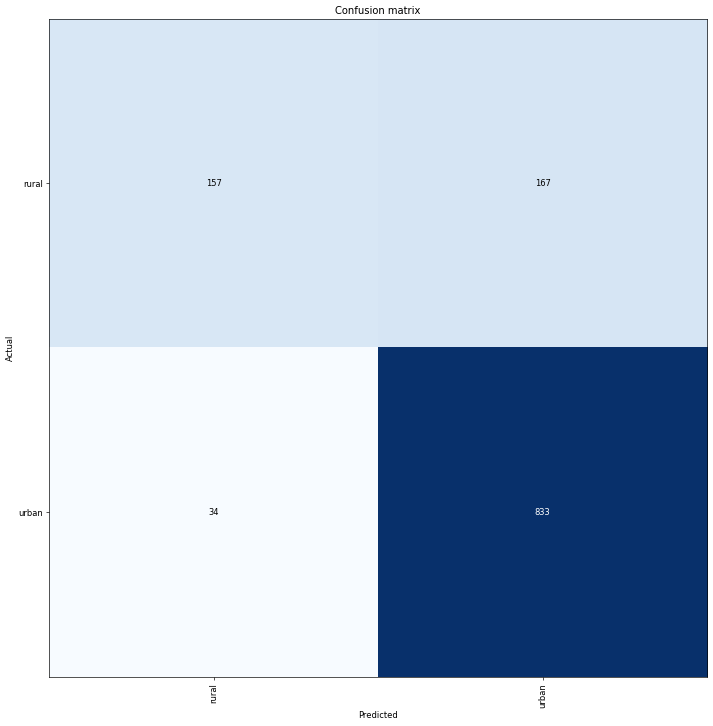

In [19]:
interp = ClassificationInterpretation.from_learner(learn_rs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [79]:
learn_rs.export('C:/Users/jwst2/Python/tesis/models/04052020_R002.pkl')

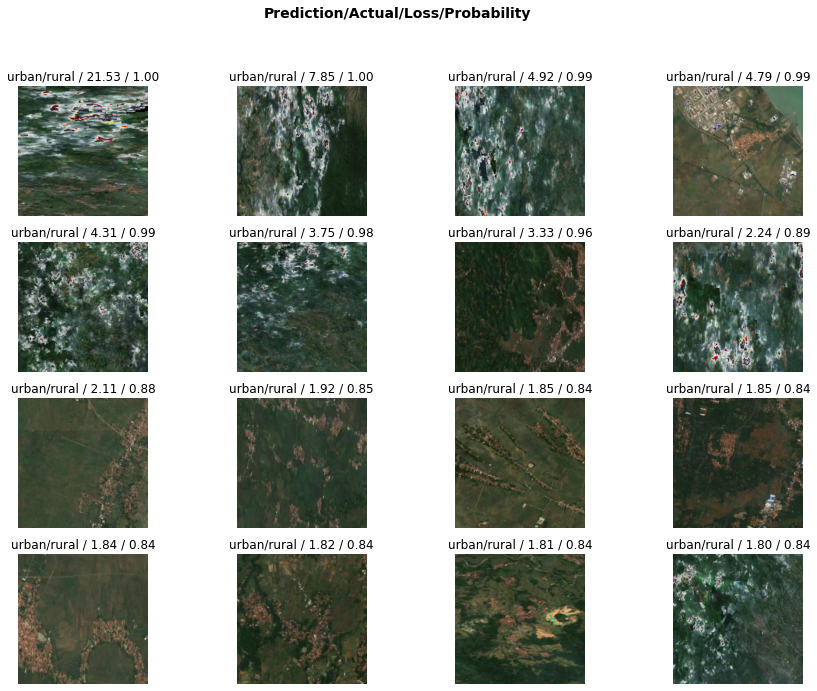

In [21]:
interp.plot_top_losses(16, figsize=(15,11))